En el presente notebook, se incluyen los códigos para:

1. Extraer la información de los datos en crudo de un PDD clínico (tomado como referencia dosimétrica). El archivo está, en este caso, en formato *.mcc*

2. Unificar los resultados obtenidos por la simulación realizada con OpenTOPAS para el cálculo de la PDD.

3. Graficar tanto los resultados medidos como los simulados para la comparación entre dichos conjuntos de datos NORMALIZADOS. También se incluye la visualización del error relativo entre PDD's.

**IMPORTACIÓN DE LIBRERÍAS NECESARIAS**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# 1. EXTRACCIÓN DE DATOS - ARCHIVOS DE PDD MEDIDOS

**Datos medidos con PTW Semiflex** (extracción de archivo .mcc):

In [ ]:
### Creación del parser del archivo ".mcc":

def parser_mcc(archivo):
  """
  Esta función lee un archivo .mcc y devuelve:
    - meta_global: un diccionario con metadatos globales del archivo ingresado
    - scans: lista de diccionarios con:
      'meta_scan': metadatos del scan
      'data': lista de tuplas (pos, ch1, ch2)
  """
  texto = Path(archivo).read_bytes().decode('latin-1', errors='ignore')
  lineas = texto.splitlines()
  meta_global = {}
  scans = []

  # Contador y límite:
  i = 0
  n = len(lineas)
  # Metadatos globales (datos antes del BEGIN_SCAN):
  while i < n:
    linea = lineas[i].rstrip("\n")
    stripped = linea.strip()
    if stripped.startswith("BEGIN_SCAN"):
      break
    if "=" in stripped and not stripped.startswith("BEGIN_"):
      key, value = stripped.split("=", 1)
      meta_global[key.strip()] = value.strip()
    i += 1
  # Scans:
  while i < n:
    linea = lineas[i].strip()
    if linea.startswith("BEGIN_SCAN"):
      scan = {"meta":{}, "data":[]}
      i += 1
      while i < n:
        s = lineas[i].strip()
        if s.startswith("END_SCAN"):
          break
        if s.startswith("BEGIN_DATA"):
          i += 1
          while i < n:
            d = lineas[i].strip()
            if d.startswith("END_DATA"):
              break
            if d:
              partes = d.split()
              if len(partes) >= 3:
                try:
                  pos = float(partes[0])
                  ch1 = float(partes[1])
                  ch2 = float(partes[2])
                  scan["data"].append((pos, ch1, ch2))
                except ValueError:
                  pass
            i += 1
        else:
          if "=" in s:
            key, value = s.split("=", 1)
            scan["meta"][key.strip()] = value.strip()
          i += 1
      scans.append(scan)
    i += 1
  return meta_global, scans

### Conversión de Scans a DataFrames:

def scans_a_dataframe(scans):
  """
  Esta función convierte la lista de scans a un único DataFrame de puntos.
  Cada fila corresponde a un punto (posición + señales) con sus metadatos principales.
  """
  filas = []
  for idx, scan in enumerate(scans, start=1):
    meta = scan["meta"]
    curve_type = meta.get("SCAN_CURVETYPE", "")
    off_inplane = float(meta.get("SCAN_OFFAXIS_INPLANE", "0") or 0)
    off_crossplane = float(meta.get("SCAN_OFFAXIS_CROSSPLANE", "0") or 0)
    ssd = float(meta.get("SSD", "0") or 0)
    energy = float(meta.get("ENERGY", "0") or 0)
    field_inplane = float(meta.get("FIELD_INPLANE", "0") or 0)
    field_crossplane = float(meta.get("FIELD_CROSSPLANE", "0") or 0)
    medium = meta.get("MEAS_MEDIUM", "")
    for pos, sig, ref in scan["data"]:
      filas.append({
          "Índice":idx,
          "Tipo de curva":curve_type,
          "Posición (mm)":pos,
          "Señal de medición":sig,
          "Señal de referencia":ref,
          "Offaxis inplane - Perfil paralelo al gantry (mm)":off_inplane,
          "Offaxis crossplane - Perfil perpendicular al gantry (mm)":off_crossplane,
          "SSD - Distancia fuente a superficie (mm)":ssd,
          "Energía (MV)":energy,
          "Campo inplane - Perfil paralelo al gantry":field_inplane,
          "Campo crossplane - Perfil perpendicular al gantry":field_crossplane,
          "Medio":medium
      })
  return pd.DataFrame(filas)

### Clasificación del tipo de curva:

def clasificacion_tipo_curva(tipo_de_curva):
  """
  Devuelve una de las categorías de curva normalizada:
    - 'PDD'
    - 'PROFILE_INPLANE'
    - 'PROFILE_CROSSPLANE'
    - 'PROFILE_OTHER'
    - 'OTHER'
  """
  if not isinstance(tipo_de_curva, str):
    return "OTHER"
  s = tipo_de_curva.upper().strip()
  if "PDD" in s or "DEPTH" in s:
    return "PDD"
  if "INPLANE" in s or "IN-PLANE" or "PARALLEL" in s:
    return "PROFILE_INPLANE"
  if "CROSSPLANE" in s or "CROSS-PLANE" or "CROSS" or "PERPENDICULAR" in s:
    return "PROFILE_CROSSPLANE"
  if "PROFILE" in s:
    return "PROFILE_OTHER"
  return "OTHER"

### Metadatos de Scans a DataFrame:

def metadatos_scans_a_dataframe(scans):
  """
  Esta función convierte los metadatos de cada scan en un DataFrame.
  Una fila por scan.
  """
  filas = []
  for idx, scan in enumerate(scans, start=1):
    meta = scan["meta"].copy()
    meta["Índice"] = idx
    filas.append(meta)
  return pd.DataFrame(filas)

### Carga y separación de DataFrames:

def carga_mcc_dataframe(archivo):
  """
  Carga un .mcc y devuelve:
    - global_meta: dict con cabecera global
    - df_scan_meta: DataFrame con metadatos por scan
    - dfs: dict con DataFrames por tipo de curva:
      'all', 'pdd', 'profile_inplane', 'profile_crossplane', 'profile_other', 'other'
    """
  meta_global, scans = parser_mcc(archivo)
  df_scans = scans_a_dataframe(scans)
  df_scans["Curva"] = df_scans["Tipo de curva"].apply(clasificacion_tipo_curva)
  df_pdd = df_scans[df_scans["Curva"] == "PDD"].copy()
  df_profile_inplane = df_scans[df_scans["Curva"] == "PROFILE_INPLANE"].copy()
  df_profile_crossplane = df_scans[df_scans["Curva"] == "PROFILE_CROSSPLANE"].copy()
  df_profile_other = df_scans[df_scans["Curva"] == "PROFILE_OTHER"].copy()
  df_other = df_scans[df_scans["Curva"] == "OTHER"].copy()
  df_scans_meta = metadatos_scans_a_dataframe(scans)
  dfs = {
    "Todas": df_scans,
    "PDD": df_pdd,
    "Perfil inplane": df_profile_inplane,
    "Perfil crossplane": df_profile_crossplane,
    "Otro perfil": df_profile_other,
    "Otro": df_other,
    }

  return meta_global, df_scans_meta, dfs

### Subida de archivo y lectura:

archivo_mcc = "X06 OPEN 10X10 PDD WAT 230131 17'03'50.mcc"
meta_global, df_scans_meta, dfs = carga_mcc_dataframe(archivo_mcc)
df_pdd_semiflex = dfs["PDD"]
# Correción de datos por señal de referencia:
df_pdd_semiflex["Dosis_corr"] = df_pdd_semiflex["Señal de medición"] / df_pdd_semiflex["Señal de referencia"]
# Normalización:
df_pdd_semiflex["Dosis_norm"] = df_pdd_semiflex["Dosis_corr"] / df_pdd_semiflex["Dosis_corr"].max()
#df_pdd_semiflex.head()
df_pdd_semiflex.tail()

,Índice,Tipo de curva,Posición (mm),Señal de medición,Señal de referencia,Offaxis inplane - Perfil paralelo al gantry (mm),Offaxis crossplane - Perfil perpendicular al gantry (mm),SSD - Distancia fuente a superficie (mm),Energía (MV),Campo inplane - Perfil paralelo al gantry,Campo crossplane - Perfil perpendicular al gantry,Medio,Curva,Dosis_corr,Dosis_norm
296,1,PDD,296.0,0.43922,1.7767,0.0,0.0,1000.0,6.0,100.0,100.0,WATER,PDD,0.247211,0.224778
297,1,PDD,297.0,0.43715,1.7767,0.0,0.0,1000.0,6.0,100.0,100.0,WATER,PDD,0.246046,0.223718
298,1,PDD,298.0,0.43315,1.7846,0.0,0.0,1000.0,6.0,100.0,100.0,WATER,PDD,0.242715,0.220690
299,1,PDD,299.0,0.43186,1.7814,0.0,0.0,1000.0,6.0,100.0,100.0,WATER,PDD,0.242427,0.220428
300,1,PDD,300.0,0.42968,1.7862,0.0,0.0,1000.0,6.0,100.0,100.0,WATER,PDD,0.240555,0.218726


**Datos medidos con BluePhysics** (extracción de archivo .csv):

In [ ]:
### Subida de archivo y lectura:

pdd_blue_file = "PDD_BluePhysics.csv"
# Creación del DataFrame:
df_pdd_blue = pd.read_csv(pdd_blue_file, skiprows=1, header=None)
df_pdd_blue.columns = ["Idx","Time", "Ch0", "Ch1", "Complete_Dose","Smooth_Dose", "Z"]
# Normalización:
df_pdd_blue["Dosis_norm"] = df_pdd_blue["Smooth_Dose"] / df_pdd_blue["Smooth_Dose"].max()
#df_pdd_blue.head()
#df_pdd_blue.tail()

# 2. TRATAMIENTO DE DATOS SIMULADOS - UNIFICACIÓN DE RESULTADOS

Para la simulación se utilizaron archivos de espacio de fase dados por la NDS, con datos simulados de un Varian TrueBeam de 6MV. Son en total 6 archivos, los cuales se suman para dar un único conjunto de datos simulados.

In [ ]:
### Archivos .csv con los datos simulados:

# Voxelización con TsBox:
pdd_box_file_01 = "PDD_Box_01.csv"
pdd_box_file_02 = "PDD_Box_02.csv"
pdd_box_file_03 = "PDD_Box_03.csv"
pdd_box_file_04 = "PDD_Box_04.csv"
pdd_box_file_05 = "PDD_Box_05.csv"
pdd_box_file_06 = "PDD_Box_06.csv"

# Voxelización con TsCylinder:
#pdd_cyl_file_01 = "PDD_Cylinder_01.csv"
#pdd_cyl_file_02 = "PDD_Cylinder_02.csv"
#pdd_cyl_file_03 = "PDD_Cylinder_03.csv"
#pdd_cyl_file_04 = "PDD_Cylinder_04.csv"
#pdd_cyl_file_05 = "PDD_Cylinder_05.csv"
#pdd_cyl_file_06 = "PDD_Cylinder_06.csv"

### Conversión de archivos a DataFrames:

# TsBox:
data_box_01 = pd.read_csv(pdd_box_file_01, skiprows=8, header=None)
data_box_01.columns = ["X", "Y", "Z", "Dosis"]
data_box_02 = pd.read_csv(pdd_box_file_02, skiprows=8, header=None)
data_box_02.columns = ["X", "Y", "Z", "Dosis"]
data_box_03 = pd.read_csv(pdd_box_file_03, skiprows=8, header=None)
data_box_03.columns = ["X", "Y", "Z", "Dosis"]
data_box_04 = pd.read_csv(pdd_box_file_04, skiprows=8, header=None)
data_box_04.columns = ["X", "Y", "Z", "Dosis"]
data_box_05 = pd.read_csv(pdd_box_file_05, skiprows=8, header=None)
data_box_05.columns = ["X", "Y", "Z", "Dosis"]
data_box_06 = pd.read_csv(pdd_box_file_06, skiprows=8, header=None)
data_box_06.columns = ["X", "Y", "Z", "Dosis"]

#TsCylinder:
#data_cyl_01 = pd.read_csv(pdd_cyl_file_01, skiprows=8, header=None)
#data_cyl_01.columns = ["X", "Y", "Z", "Dosis"]
#data_cyl_02 = pd.read_csv(pdd_cyl_file_02, skiprows=8, header=None)
#data_cyl_02.columns = ["X", "Y", "Z", "Dosis"]
#data_cyl_03 = pd.read_csv(pdd_cyl_file_03, skiprows=8, header=None)
#data_cyl_03.columns = ["X", "Y", "Z", "Dosis"]
#data_cyl_04 = pd.read_csv(pdd_cyl_file_04, skiprows=8, header=None)
#data_cyl_04.columns = ["X", "Y", "Z", "Dosis"]
#data_cyl_05 = pd.read_csv(pdd_cyl_file_05, skiprows=8, header=None)
#data_cyl_05.columns = ["X", "Y", "Z", "Dosis"]
#data_cyl_06 = pd.read_csv(pdd_cyl_file_06, skiprows=8, header=None)
#data_cyl_06.columns = ["X", "Y", "Z", "Dosis"]

### Suma de DataFrames:

# TsBox:
df_box = pd.DataFrame()
df_box["Z"] = np.arange(-2, 30, 0.1)
df_box["Dosis"] = data_box_01["Dosis"] + data_box_02["Dosis"] + data_box_03["Dosis"] + data_box_04["Dosis"] + data_box_05["Dosis"] + data_box_06["Dosis"]

# TsCylinder:
#df_cyl = pd.DataFrame()
#df_cyl["Z"] = np.arange(-2, 30, 0.1)
#df_cyl["Dosis"] = data_cyl_01["Dosis"] + data_cyl_02["Dosis"] + data_cyl_03["Dosis"] + data_cyl_04["Dosis"] + data_cyl_05["Dosis"] + data_cyl_06["Dosis"]

### Máximo de dosis y normalización:

# TsBox:
pdd_box_max = df_box["Dosis"].max()
df_box["Dosis_norm"] = df_box["Dosis"] / pdd_box_max

# TsCylinder:
#pdd_cyl_max = df_cyl["Dosis"].max()
#df_cyl["Dosis_norm"] = df_cyl["Dosis"] / pdd_cyl_max

# 3. GRÁFICAS Y PRESENTACIÓN DE RESULTADOS

Verificación - Curvas individuales:

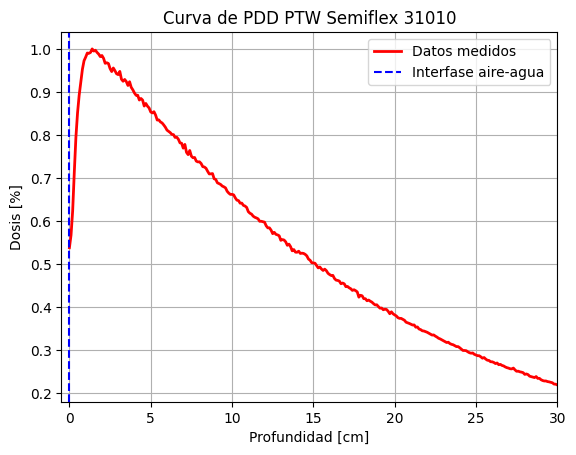

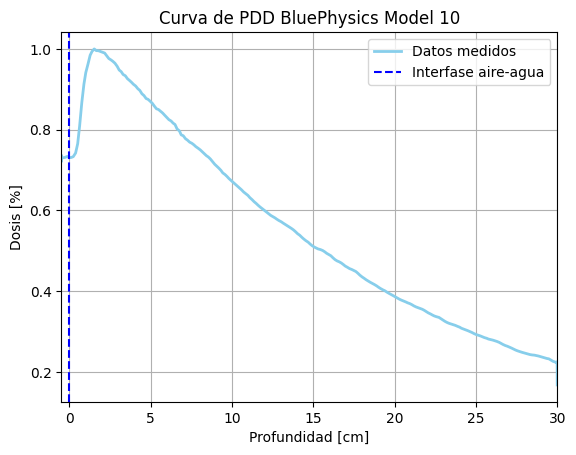

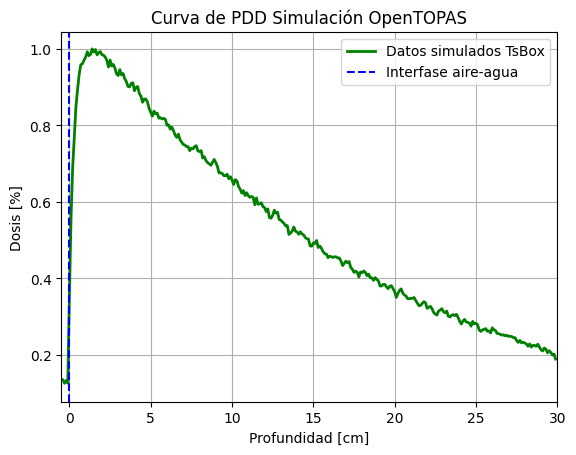

In [ ]:
### Datos medidos con PTW Semiflex

plt.plot(df_pdd_semiflex["Posición (mm)"]/10, df_pdd_semiflex["Dosis_norm"], linewidth = 2.0, color = "red", label = "Datos medidos")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-0.5, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curva de PDD PTW Semiflex 31010')
plt.grid(True)
plt.legend()
plt.show()

### Datos medidos con BluePhysics:

plt.plot(df_pdd_blue["Z"]/10, df_pdd_blue["Dosis_norm"], linewidth = 2.0, color = "skyblue", label = "Datos medidos")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-0.5, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curva de PDD BluePhysics Model 10')
plt.grid(True)
plt.legend()
plt.show()

### Datos simulados con OpenTOPAS:

# TsBox:
plt.plot(df_box["Z"], df_box["Dosis_norm"], linewidth = 2.0, color = "green", label = "Datos simulados TsBox")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-0.5, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curva de PDD Simulación OpenTOPAS')
plt.grid(True)
plt.legend()
plt.show()

# TsCylinder:
#plt.plot(df_cyl["Z"], df_cyl["Dosis_norm"], linewidth = 2.0, color = "violet", label = "Datos simulados TsCylinder")
#plt.xlabel('Profundidad [cm]')
#plt.ylabel('Dosis [%]')
#plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
#plt.title('Curva de PDD Simulación OpenTOPAS')
#plt.grid(True)
#plt.legend()
#plt.show()

Sobreposición de gráficas

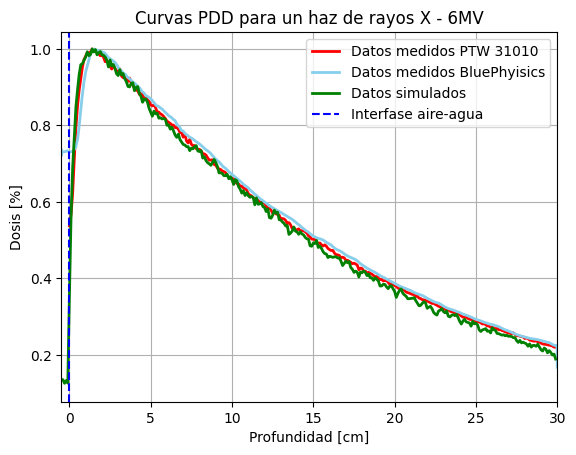

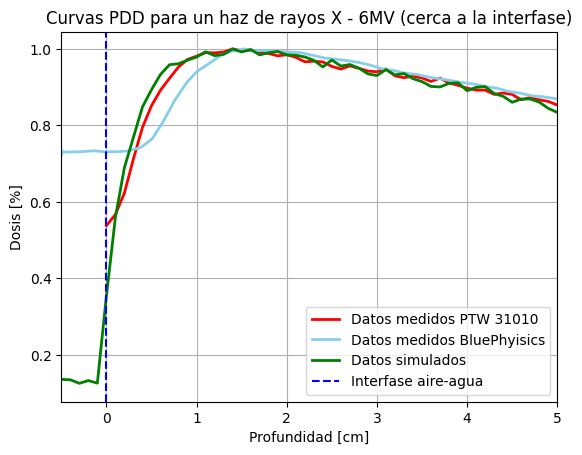

In [ ]:
plt.plot(df_pdd_semiflex["Posición (mm)"]/10, df_pdd_semiflex["Dosis_norm"], linewidth = 2.0, color = "red", label = "Datos medidos PTW 31010")
plt.plot(df_pdd_blue["Z"]/10, df_pdd_blue["Dosis_norm"], linewidth = 2.0, color = "skyblue", label = "Datos medidos BluePhyisics")
plt.plot(df_box["Z"], df_box["Dosis_norm"], linewidth = 2.0, color = "green", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-0.5, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curvas PDD para un haz de rayos X - 6MV')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(df_pdd_semiflex["Posición (mm)"]/10, df_pdd_semiflex["Dosis_norm"], linewidth = 2.0, color = "red", label = "Datos medidos PTW 31010")
plt.plot(df_pdd_blue["Z"]/10, df_pdd_blue["Dosis_norm"], linewidth = 2.0, color = "skyblue", label = "Datos medidos BluePhyisics")
plt.plot(df_box["Z"], df_box["Dosis_norm"], linewidth = 2.0, color = "green", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-0.5, 5)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curvas PDD para un haz de rayos X - 6MV (cerca a la interfase)')
plt.grid(True)
plt.legend()
plt.show()

Errores relativos

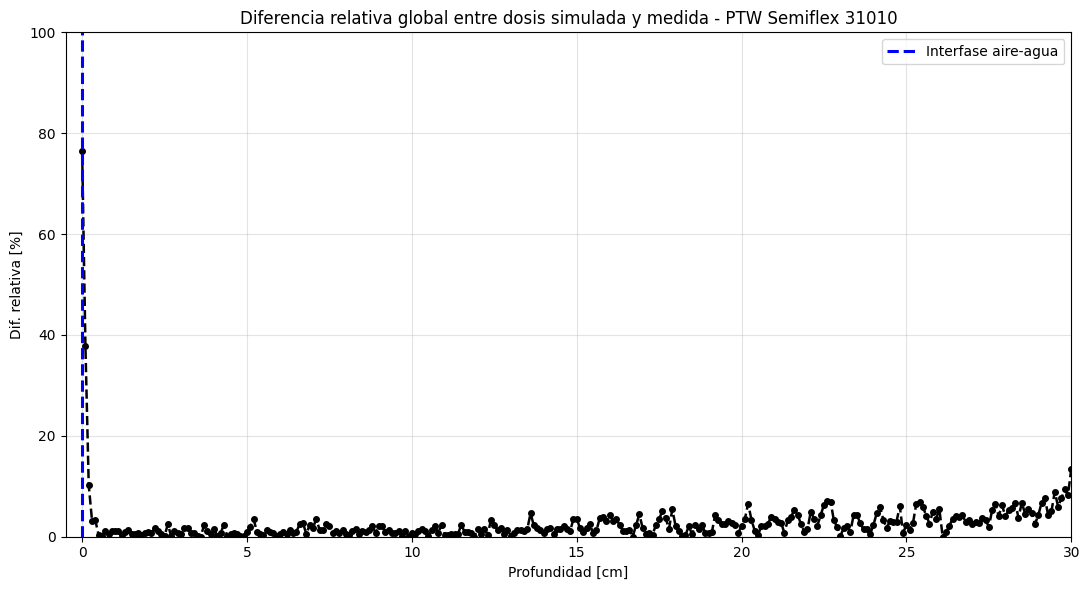

In [ ]:
### Para PTW Semiflex

dose_box = df_box.to_numpy()[:,2]
dose_semi = df_pdd_semiflex["Dosis_norm"].to_numpy()
diff_relat_semibox = 100*np.abs(dose_semi - dose_box[19:])/dose_semi
plt.figure(figsize=(11, 6))
plt.plot(df_pdd_semiflex["Posición (mm)"]/10, diff_relat_semibox, "--.k", linewidth=1.8, markersize = 8)
plt.axvline(x = 0, color = 'b', linestyle = '--', linewidth=2.2, label = 'Interfase aire-agua')
plt.xlabel("Profundidad [cm]")
plt.ylabel("Dif. relativa [%]")
plt.xlim(-0.5, 30)
plt.ylim(0, 100)
plt.grid(True, alpha=0.35)
plt.title("Diferencia relativa global entre dosis simulada y medida - PTW Semiflex 31010")
plt.tight_layout()
plt.savefig("PDDGlobal_DiferenciaPorcentual.png", dpi=600)
plt.legend()
plt.show()